In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import probplot

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
train = pd.read_csv('../input/black-friday-sales-prediction/train_oSwQCTC (1)/train.csv')
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
train.shape

(550068, 12)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [6]:
train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [7]:
train.duplicated().sum()

0

In [8]:
train['Product_Category_2'].fillna(train['Product_Category_2'].mean(),inplace=True)
train['Product_Category_3'].fillna(train['Product_Category_3'].mean(),inplace=True)

In [9]:
train.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

In [10]:
train['Gender'].value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

In [11]:
encoded_gender = {'M': 0, 'F': 1}
train['Gender'] = train['Gender'].map(encoded_gender)
train.Gender = train.Gender.astype(int)

                                              User_ID                                               
Skewness: 0.0030655518513462644
Kurtosis: -1.1955007812357379


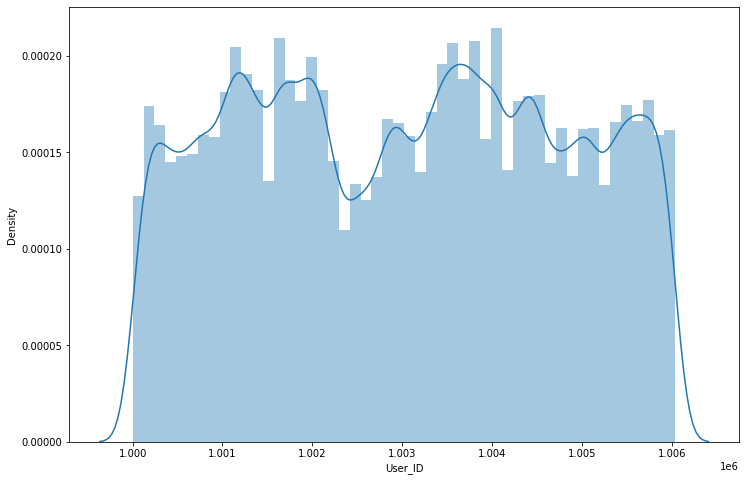

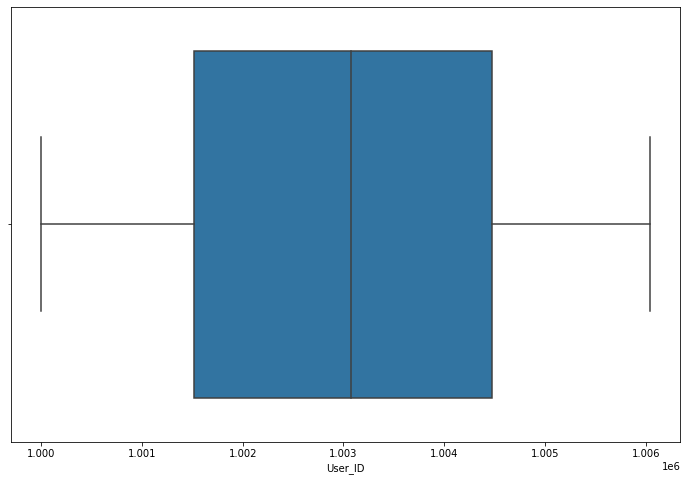

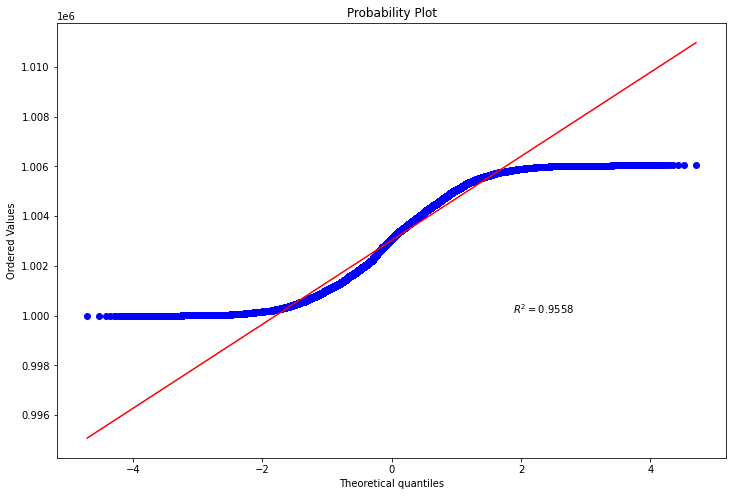

                                               Gender                                               
Skewness: 1.173946092449046
Kurtosis: -0.6218528330403248


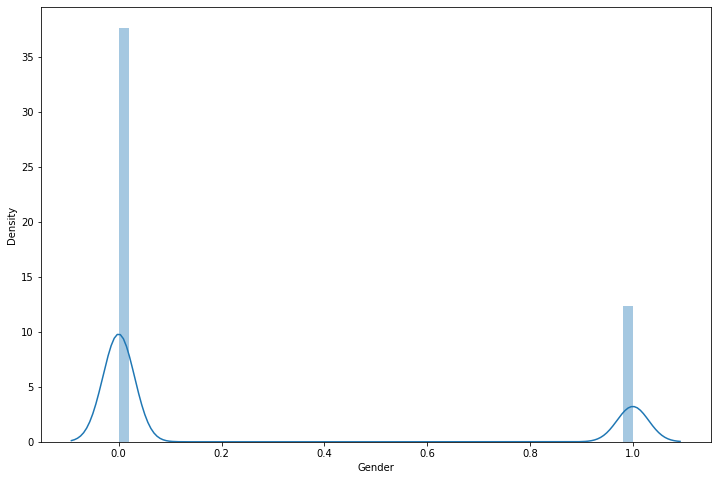

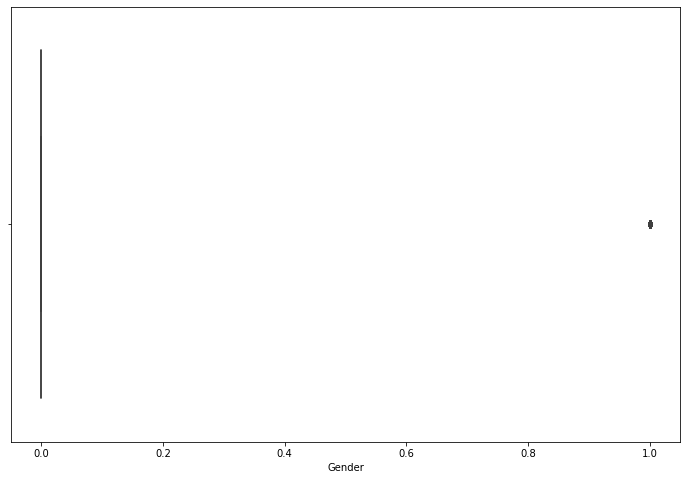

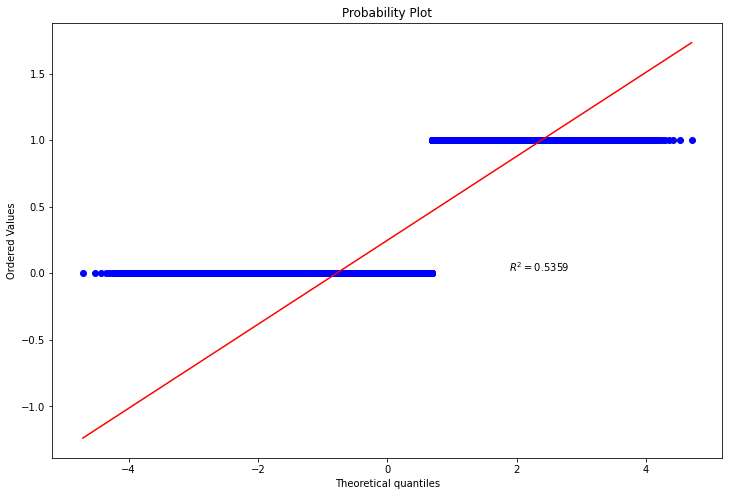

                                             Occupation                                             
Skewness: 0.40014010986184784
Kurtosis: -1.21611364874086


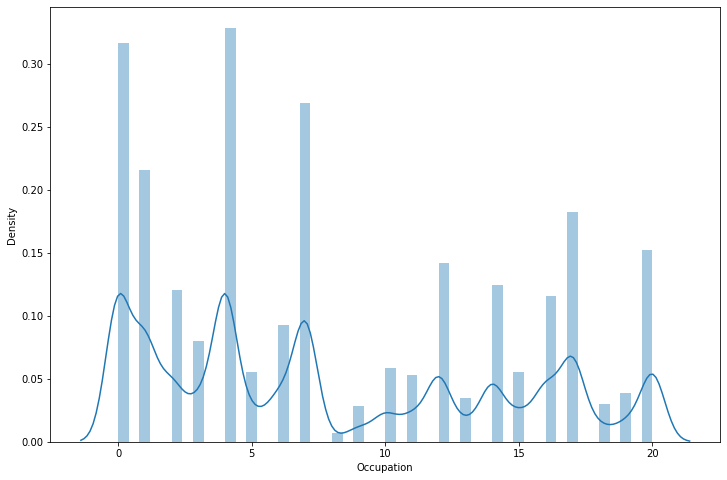

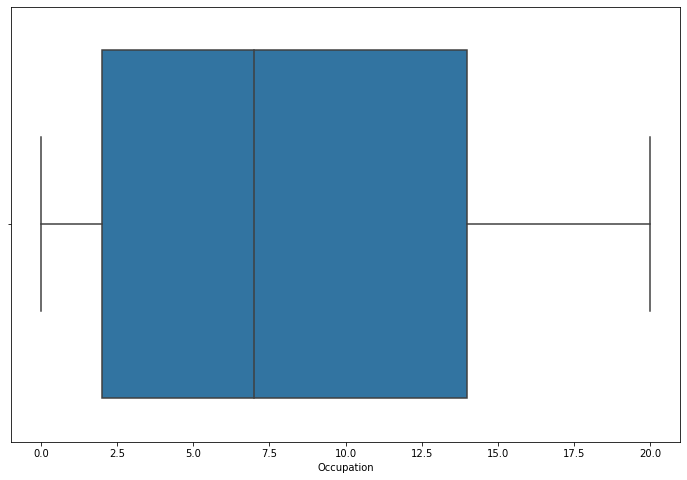

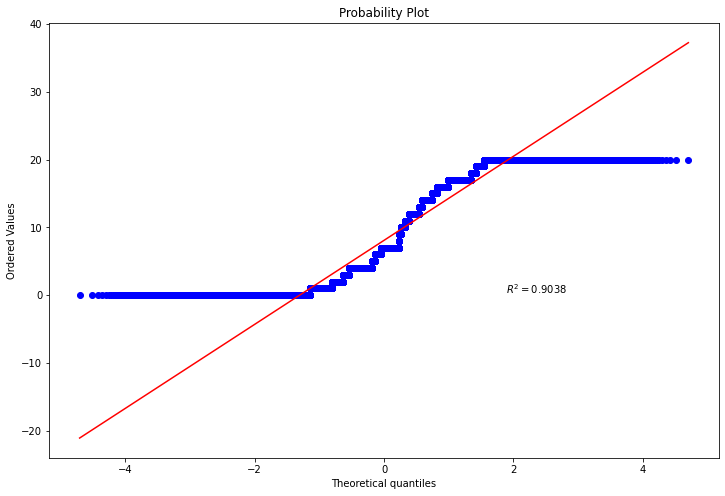

                                           Marital_Status                                           
Skewness: 0.3674372854404167
Kurtosis: -1.8649966222489232


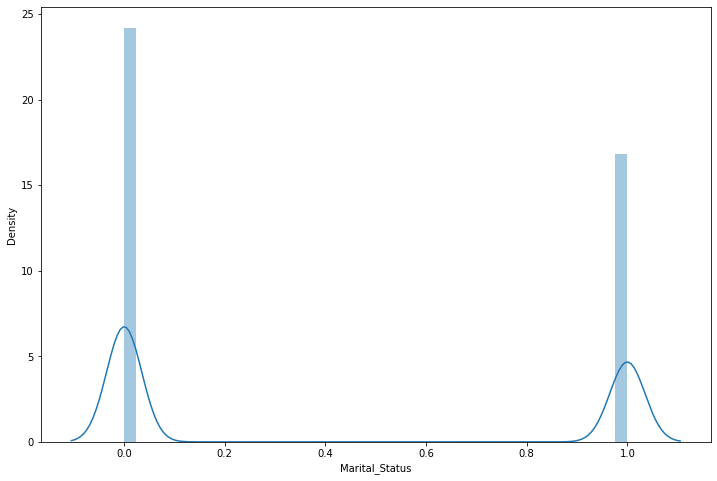

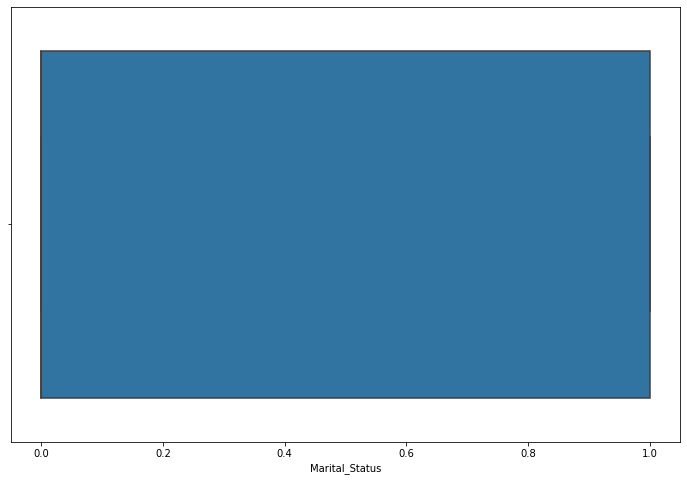

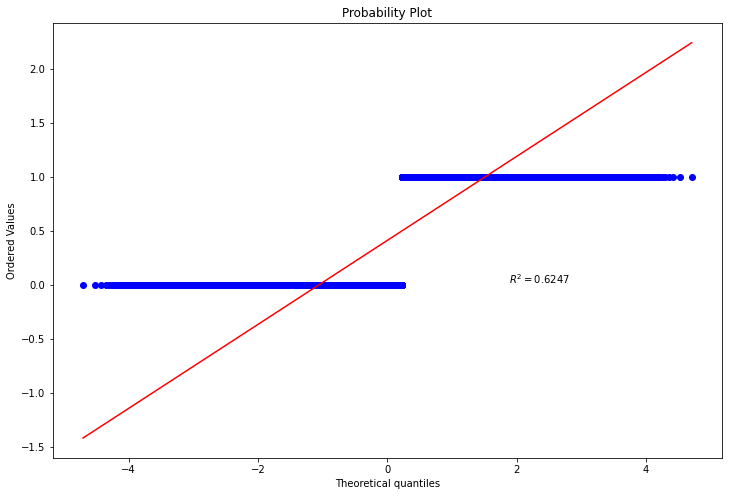

                                         Product_Category_1                                         
Skewness: 1.0257349338538029
Kurtosis: 1.2347569716913842


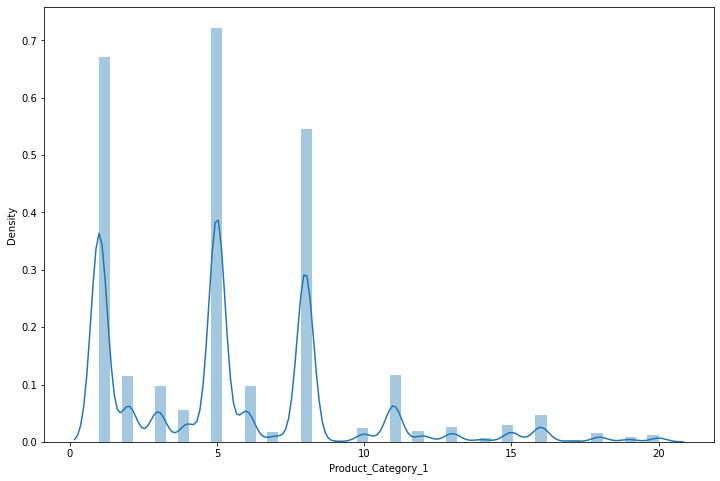

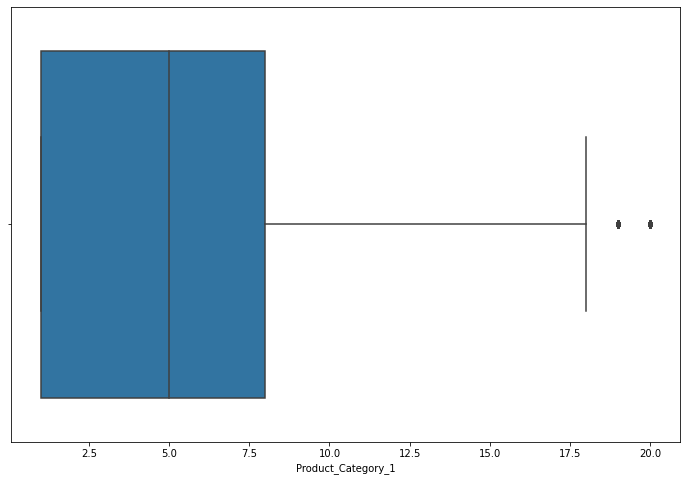

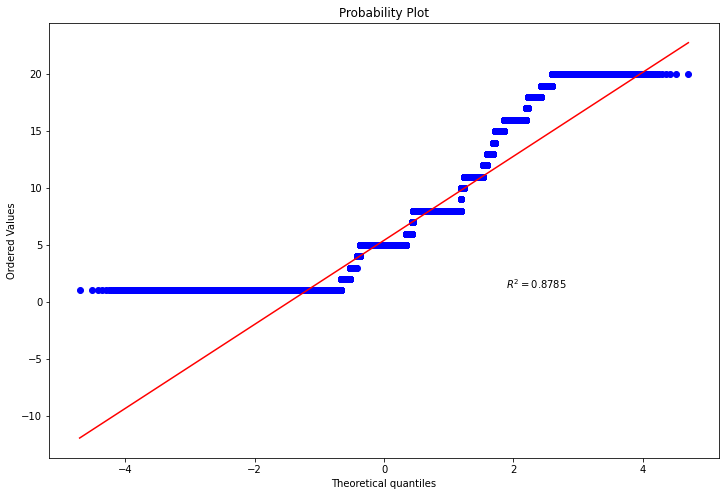

                                         Product_Category_2                                         
Skewness: -0.19674654415192747
Kurtosis: -0.7091007945191348


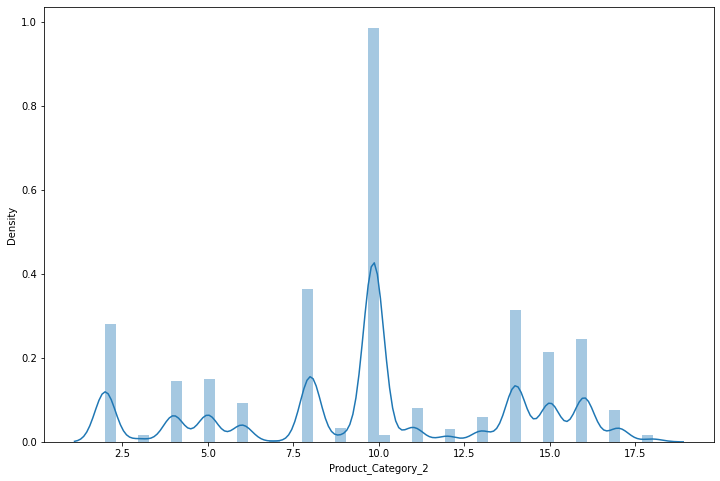

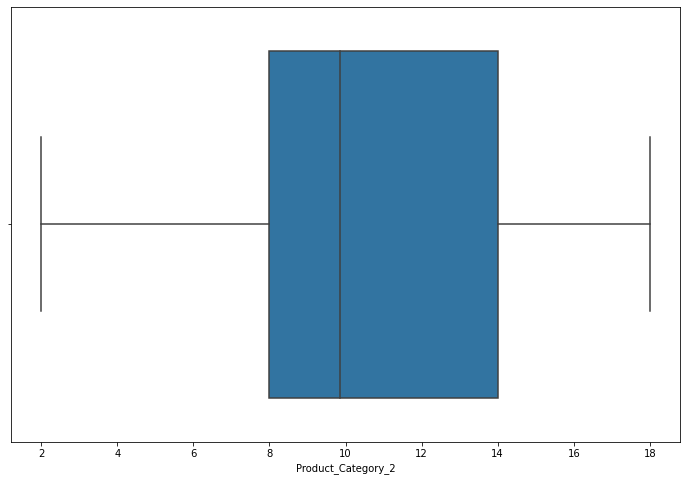

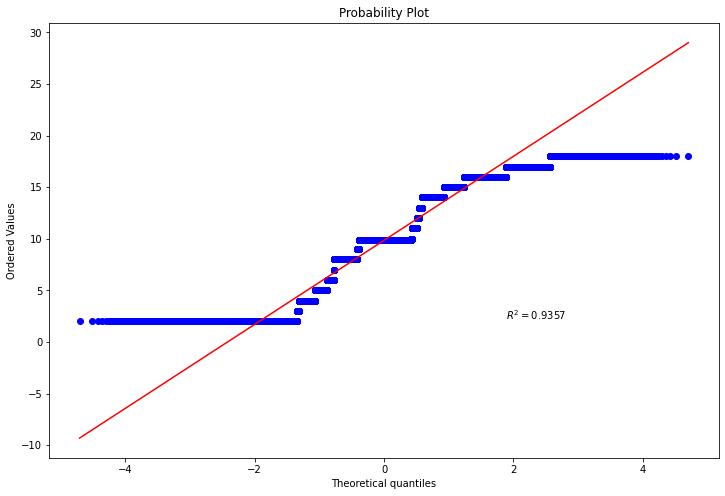

                                         Product_Category_3                                         
Skewness: -1.3899353636558347
Kurtosis: 4.227593988084336


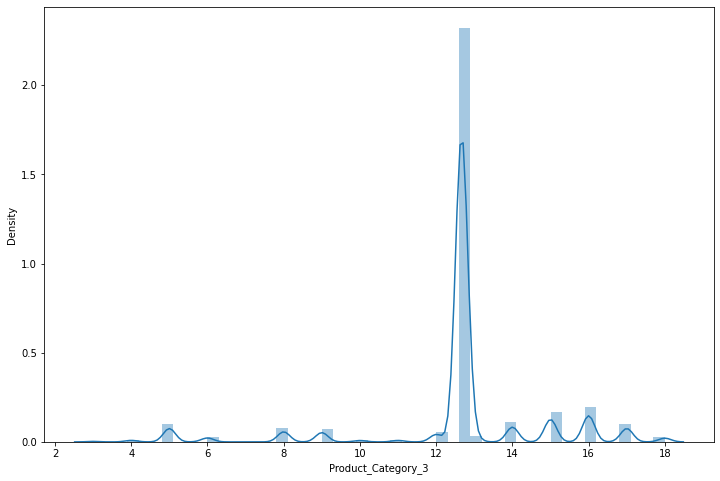

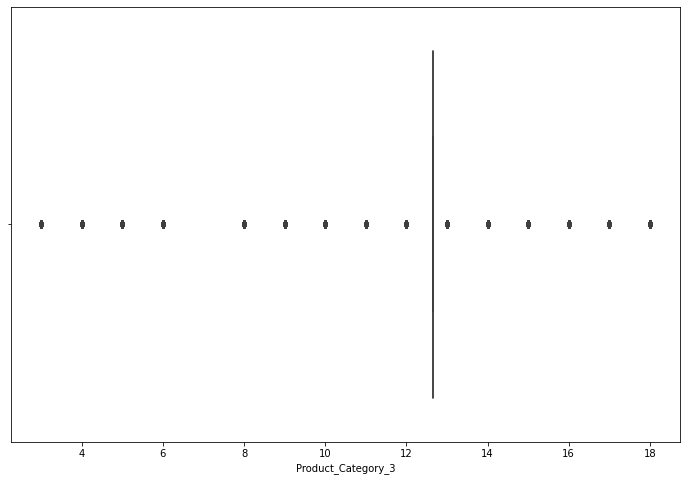

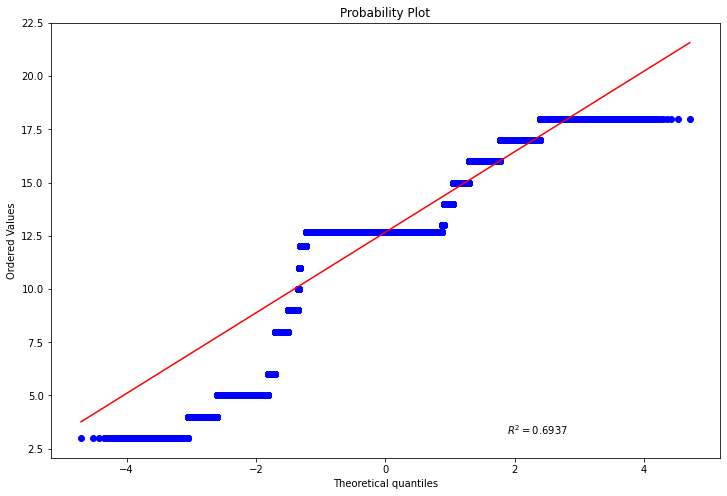

                                              Purchase                                              
Skewness: 0.6001400037087128
Kurtosis: -0.3383775655851702


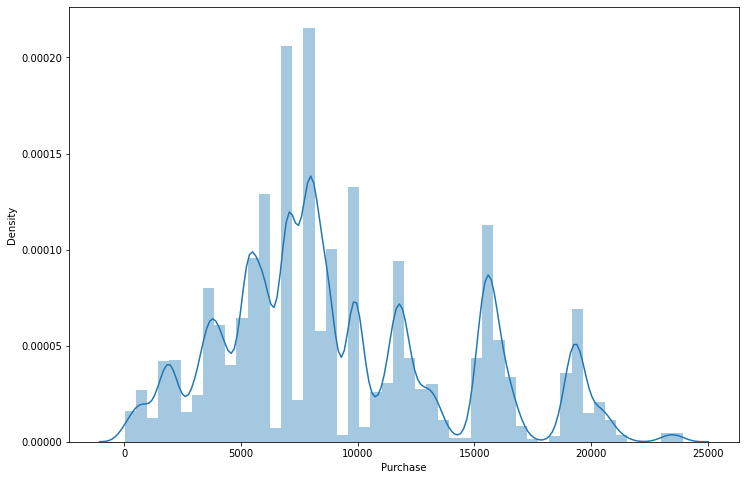

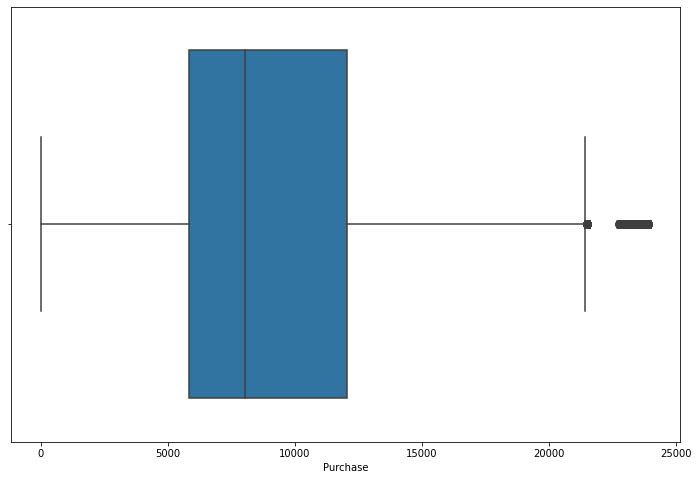

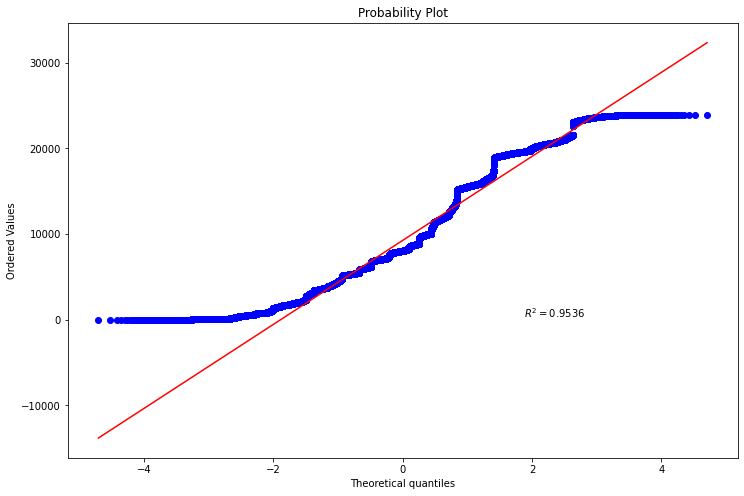

In [12]:
for col in train.columns:
    if train[col].dtypes == np.int64 or train[col].dtypes == np.float64:
        print(f"{col: ^100}")
        print("Skewness:".format(col),train[col].skew())
        print("Kurtosis:".format(col),train[col].kurtosis())
        sns.distplot(train[col])
        plt.show()
        sns.boxplot(train[col])
        plt.show()
        probplot(train[col],rvalue=True,plot=plt)
        plt.show();

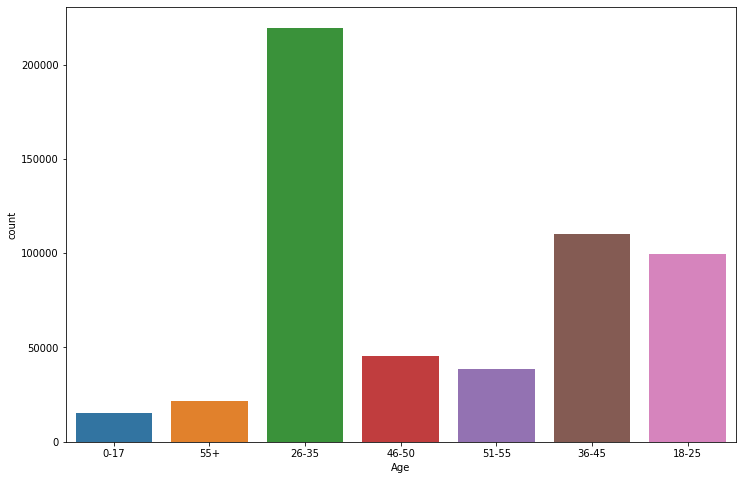

In [13]:
sns.countplot(train['Age']);

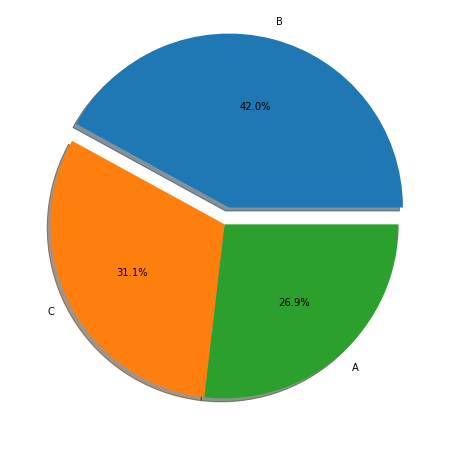

In [14]:
plt.figure(figsize=(12,8))
values = train['City_Category'].value_counts().values
labels = train['City_Category'].value_counts().keys()
explode = (0.1,0,0)
plt.pie(values,labels=labels,explode=explode,shadow=True,autopct='%1.1f%%');

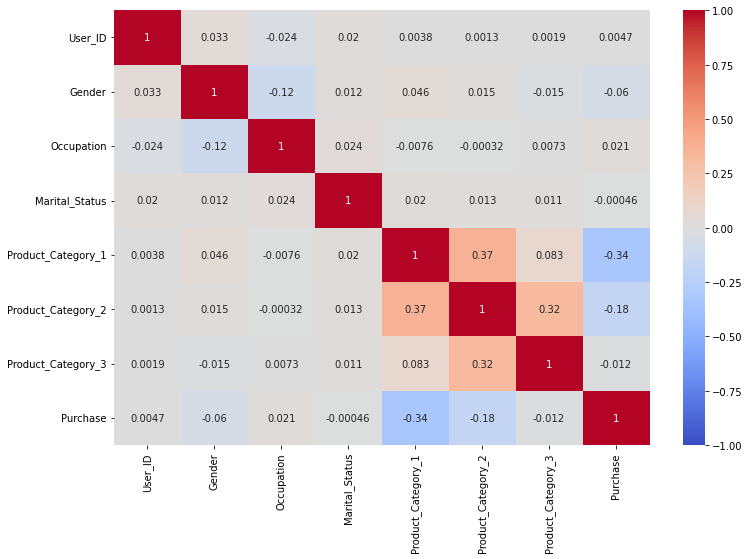

In [15]:
sns.heatmap(train.corr(),annot=True,cmap='coolwarm',vmin=-1,vmax=1);

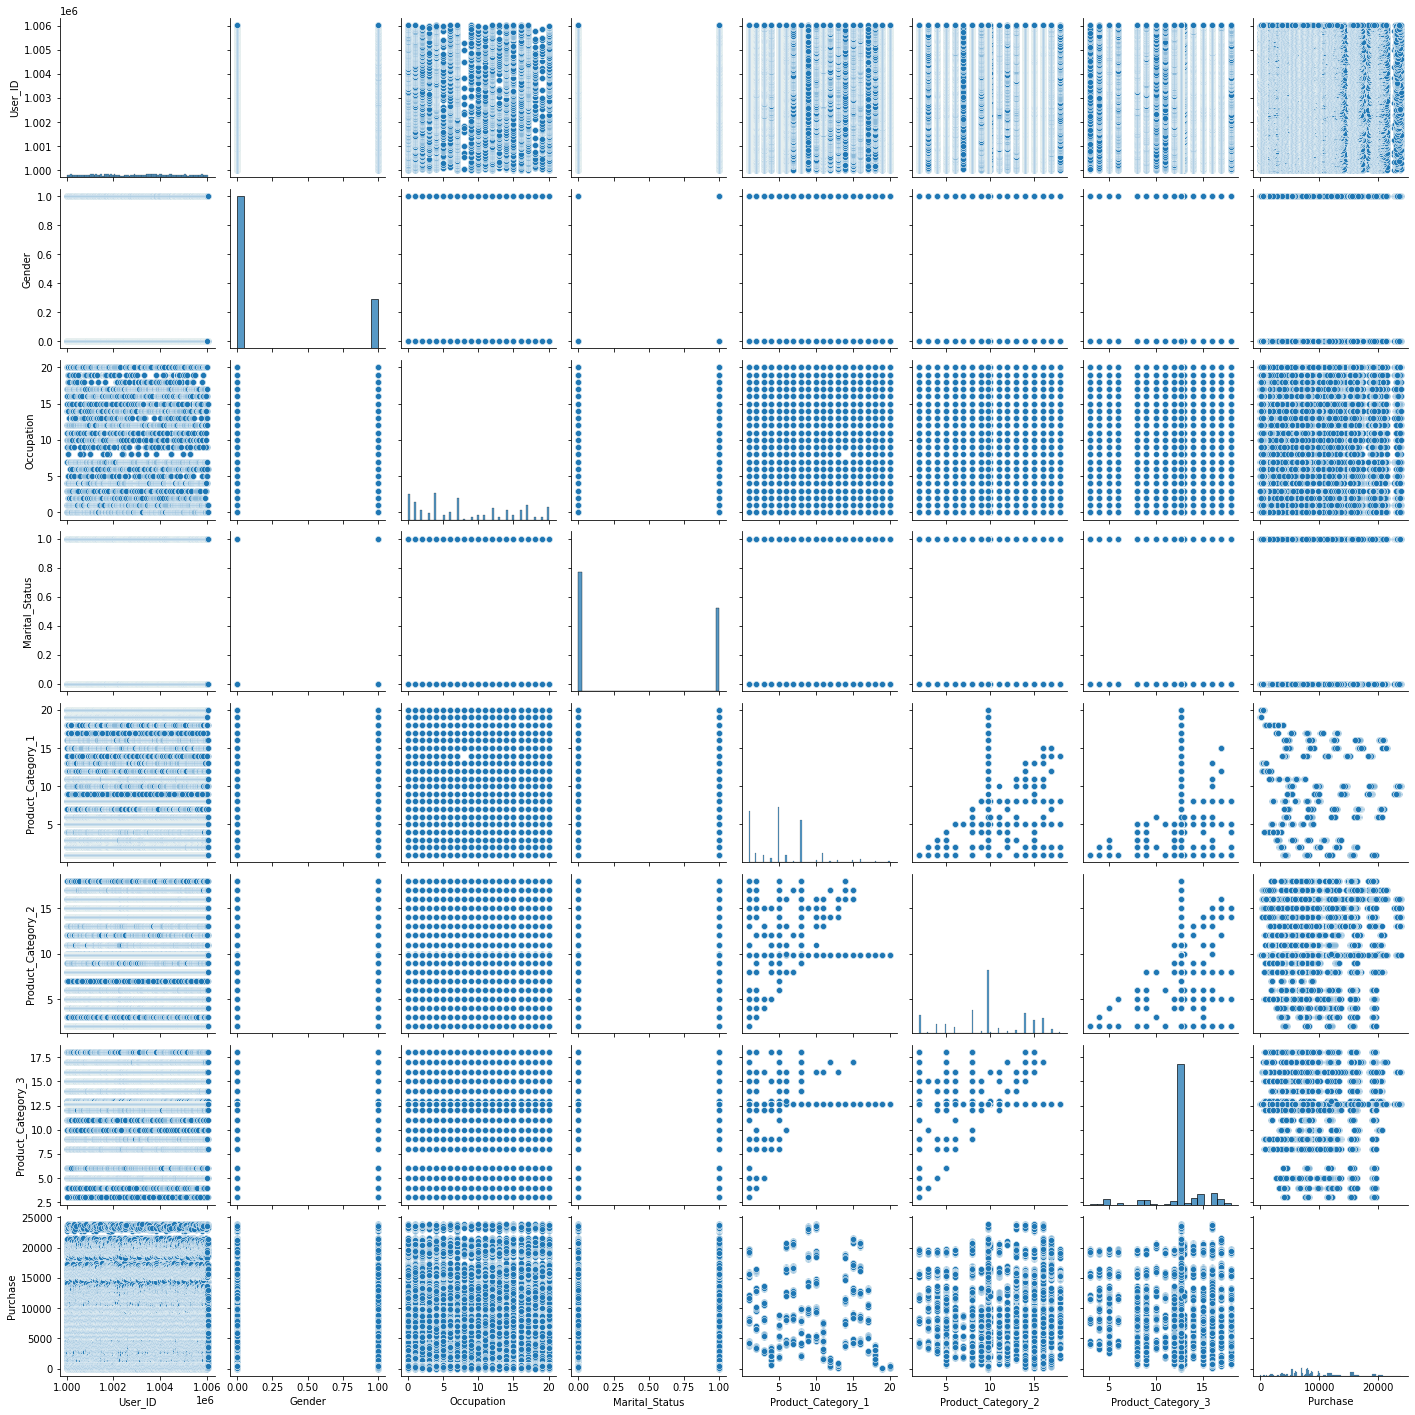

In [16]:
sns.pairplot(train,palette='winter');

In [17]:
train['Stay_In_Current_City_Years'].replace('4+','4',inplace=True)

In [18]:
train['Stay_In_Current_City_Years'] = train['Stay_In_Current_City_Years'].astype(int)

In [19]:
city_categories = {'A': 1, 'B': 2, 'C': 3}
train['City_Category'] = train['City_Category'].map(city_categories)
train['City_Category'].head()

0    1
1    1
2    1
3    1
4    3
Name: City_Category, dtype: int64

In [20]:
train['City_Category'] = train['City_Category'].astype(int)

In [21]:
le = LabelEncoder()
train.Product_ID = le.fit_transform(train.Product_ID)

In [22]:
train['Age'] = le.fit_transform(train['Age'])
train['Age'] = train['Age'].astype(int)
train['Age'].dtypes

dtype('int64')

In [23]:
test = pd.read_csv('../input/black-friday-sales-prediction/test_HujdGe7 (1)/test.csv')
test_c = test.copy()
test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


In [24]:
test.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

In [25]:
test['Product_Category_2'].fillna(test['Product_Category_2'].mean(),inplace=True)
test['Product_Category_3'].fillna(test['Product_Category_3'].mean(),inplace=True)
test['Gender'] = test['Gender'].map(encoded_gender)
test['Gender'] = test['Gender'].astype(int)
test['Age'] = le.fit_transform(test['Age'])
test['Age'] = test['Age'].astype(int)
test['City_Category'] = test['City_Category'].map(city_categories)
test['City_Category'] = test['City_Category'].astype(int)
test['Stay_In_Current_City_Years'].replace('4+','4',inplace=True)
test['Stay_In_Current_City_Years'] = test['Stay_In_Current_City_Years'].astype(int)
test['Product_ID'] = le.fit_transform(test['Product_ID'])

In [26]:
test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,1144,0,4,7,2,2,1,1,11.0,12.669454
1,1000009,994,0,2,17,3,0,0,3,5.0,12.669454
2,1000010,2672,1,3,1,2,4,1,5,14.0,12.669454
3,1000010,1299,1,3,1,2,4,1,4,9.0,12.669454
4,1000011,519,1,2,1,3,1,0,4,5.0,12.000000


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     233599 non-null  int64  
 1   Product_ID                  233599 non-null  int64  
 2   Gender                      233599 non-null  int64  
 3   Age                         233599 non-null  int64  
 4   Occupation                  233599 non-null  int64  
 5   City_Category               233599 non-null  int64  
 6   Stay_In_Current_City_Years  233599 non-null  int64  
 7   Marital_Status              233599 non-null  int64  
 8   Product_Category_1          233599 non-null  int64  
 9   Product_Category_2          233599 non-null  float64
 10  Product_Category_3          233599 non-null  float64
dtypes: float64(2), int64(9)
memory usage: 19.6 MB


In [28]:
assert len(train.columns) == len(test.columns) + 1

In [29]:
X = train.drop('Purchase',axis=1)
y = train['Purchase']
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.15,random_state=1)

In [30]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',Lasso(alpha=4))
])

In [31]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()), ('model', Lasso(alpha=4))])

In [32]:
pred = pipeline.predict(X_val)
print("RMSE of Lasso Regression:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of Lasso Regression:",r2_score(y_val,pred))

RMSE of Lasso Regression: 4671.806838395531
R2 Score of Lasso Regression: 0.13773389263927927


In [33]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',LinearRegression())
])

In [34]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()), ('model', LinearRegression())])

In [35]:
pred = pipeline.predict(X_val)
print("RMSE of Linear Regression:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of Linear Regression:",r2_score(y_val,pred))

RMSE of Linear Regression: 4671.702798191703
R2 Score of Linear Regression: 0.13777229719912132


In [36]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',DecisionTreeRegressor())
])

In [37]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('model', DecisionTreeRegressor())])

In [38]:
pred = pipeline.predict(X_val)
print("RMSE of Decision Tree Regressor:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of Decision Tree Regressor:",r2_score(y_val,pred))

RMSE of Decision Tree Regressor: 3746.599444496104
R2 Score of Decision Tree Regressor: 0.44544313160072524


In [39]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',RandomForestRegressor())
])

In [40]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('model', RandomForestRegressor())])

In [41]:
pred = pipeline.predict(X_val)
print("RMSE of Random Forest Regressor:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of Random Forest Regressor:",r2_score(y_val,pred))

RMSE of Random Forest Regressor: 2731.022581752604
R2 Score of Random Forest Regressor: 0.7053393502901986


In [42]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',XGBRegressor())
])

In [43]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                           

In [44]:
pred = pipeline.predict(X_val)
print("RMSE of XG Boost Regressor:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of XG Boost Regressor:",r2_score(y_val,pred))

RMSE of XG Boost Regressor: 2615.86894595869
R2 Score of XG Boost Regressor: 0.7296642236613607


In [45]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',CatBoostRegressor(silent=True))
])

In [46]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7ffa1a7d7a90>)])

In [47]:
pred = pipeline.predict(X_val)
print("RMSE of Cat Boost Regressor:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of Cat Boost Regressor:",r2_score(y_val,pred))

RMSE of Cat Boost Regressor: 2650.420379880323
R2 Score of Cat Boost Regressor: 0.7224756562325501


In [48]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',GradientBoostingRegressor())
])

In [49]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('model', GradientBoostingRegressor())])

In [50]:
pred = pipeline.predict(X_val)
print("RMSE of Gradient Boosting Regressor:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of Gradient Boosting Regressor:",r2_score(y_val,pred))

RMSE of Gradient Boosting Regressor: 2921.7467703381913
R2 Score of Gradient Boosting Regressor: 0.6627463139184505


In [51]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',ExtraTreesRegressor())
])

In [52]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('model', ExtraTreesRegressor())])

In [53]:
pred = pipeline.predict(X_val)
print("RMSE of Extra Trees Regressor:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of Extra Trees Regressor:",r2_score(y_val,pred))

RMSE of Extra Trees Regressor: 2865.2815132505993
R2 Score of Extra Trees Regressor: 0.6756557857597452


In [54]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',BaggingRegressor())
])

In [55]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()), ('model', BaggingRegressor())])

In [56]:
pred = pipeline.predict(X_val)
print("RMSE of Bagging Regressor:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of Bagging Regressor:",r2_score(y_val,pred))

RMSE of Bagging Regressor: 2851.00079116428
R2 Score of Bagging Regressor: 0.67888082791701


In [57]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',LGBMRegressor())
])

In [58]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()), ('model', LGBMRegressor())])

In [59]:
pred = pipeline.predict(X_val)
print("RMSE of Light Gradient Boosting Regressor:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of Light Gradient Bagging Regressor:",r2_score(y_val,pred))

RMSE of Light Gradient Boosting Regressor: 2751.1462881269917
R2 Score of Light Gradient Bagging Regressor: 0.700980901567444


In [60]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',KNeighborsRegressor())
])

In [61]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('model', KNeighborsRegressor())])

In [62]:
pred = pipeline.predict(X_val)
print("RMSE of K Nearest Neighbors Regressor:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of K Nearest Neighbors Regressor:",r2_score(y_val,pred))

RMSE of K Nearest Neighbors Regressor: 3866.7817843729813
R2 Score of K Nearest Neighbors Regressor: 0.4092946722821783


In [63]:
pipeline = Pipeline(steps=[
    ('scaling',StandardScaler()),
    ('model',LinearSVR())
])

In [64]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()), ('model', LinearSVR())])

In [65]:
pred = pipeline.predict(X_val)
print("RMSE of Linear Support Vector Regressor:",np.sqrt(mean_squared_error(y_val,pred)))
print("R2 Score of Linear Support Vector Regressor:",r2_score(y_val,pred))

RMSE of Linear Support Vector Regressor: 4753.683904110437
R2 Score of Linear Support Vector Regressor: 0.10724527027233743


Among the baseline models, XGBoost Regressor model exhibited the best performance producing R2 score of almost 73% on the validation data.

## Making predictions on the test data

In [66]:
scaler = StandardScaler()
features = test.columns
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(test)
scaled_test = pd.DataFrame(test,columns=features)
scaled_test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,1144,0,4,7,2,2,1,1,11.0,12.669454
1,1000009,994,0,2,17,3,0,0,3,5.0,12.669454
2,1000010,2672,1,3,1,2,4,1,5,14.0,12.669454
3,1000010,1299,1,3,1,2,4,1,4,9.0,12.669454
4,1000011,519,1,2,1,3,1,0,4,5.0,12.000000


In [67]:
model = XGBRegressor()
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [68]:
test_pred = model.predict(scaled_test)
test_pred

array([14159.415 ,  9647.569 ,  6242.0083, ...,  9906.611 , 20352.865 ,
        1490.6665], dtype=float32)